In [1]:
import sys
sys.path.append('..')

In [2]:
from pathlib import Path
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

from myutils.matplotlib import matplotlib_seaborn_style, matplotlib_latex

from src.missing_values import impute_average
from src.pca import ImputePCA

matplotlib_seaborn_style()
matplotlib_latex(serif=False)

In [3]:
figures_dir = Path('../data/report_figures')
figures_dir.mkdir(exist_ok=True)

In [4]:
data = pd.read_csv('../data/data.csv', parse_dates=['date'])

for col in ['class', 'train']:
    data[col] = data[col].str.replace('Сидячий', 'Сидячий')

data['weekday'] = data['date'].dt.weekday
data['day_name'] = data['date'].dt.day_name()

weekdays = data[['weekday', 'day_name']].drop_duplicates().sort_values(by='weekday')\
    .set_index('weekday')['day_name'].to_dict()

data.head(2)

,date,days,places,price,num,class,train,departure_hour,arrival_hour,places_frac,weekday,day_name
0,2021-04-12,1,28.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,0.200000,0,Monday
1,2021-04-13,1,52.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,0.371429,1,Tuesday


In [58]:
# all_dates = np.arange(data['date'].min(), data['date'].max() + timedelta(days=1), timedelta(days=1))
all_dates = np.arange(datetime(2021, 5, 16), datetime(2021, 6, 29), timedelta(days=1))

In [59]:
trains = ['760А-C2', '768А-C2']
days = [2, 4, 7]

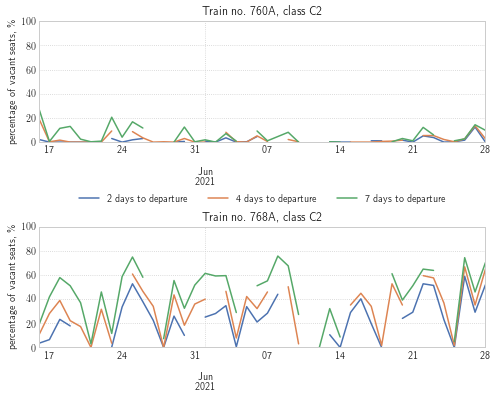

In [60]:
fig, axes = plt.subplots(nrows=len(trains))
fig.set_size_inches(8, 6)
fig.subplots_adjust(hspace=0.7)
axes = axes.flatten()

for train, ax in zip(trains, axes):
    for i, day in enumerate(days):
        ts = data[(data['train'] == train) & (data['days'] == day)]\
            .set_index('date')['places_frac'].reindex(all_dates) * 100
        
        ts.plot(ax=ax, c=f'C{i}', label=f'{day} days to departure')
        
    ax.set_xlabel(None)
    ax.set_ylabel('percentage of vacant seats, \\%')
    ax.set_ylim(0, 100)
    
    num, cls = train.split('-')
    ax.set_title(f'Train no. {num}, class {cls}')
    
axes[0].legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.35))

plt.savefig(figures_dir / 'seat_dynamics_dates.pdf', transparent=True, bbox_inches='tight')

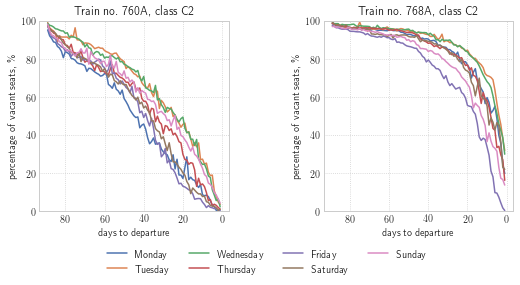

In [8]:
fig, axes = plt.subplots(ncols=len(trains))
fig.set_size_inches(8.5, 3.5)
fig.subplots_adjust(wspace=0.5)
axes = axes.flatten()

for train, ax in zip(trains, axes):
    for i, weekday in weekdays.items():
        ts = data[(data['train'] == train) & (data['day_name'] == weekday)]\
            .groupby('days')['places_frac'].mean() * 100
        
        ts.plot(ax=ax, c=f'C{i}', label=weekday)
        
    ax.invert_xaxis()
    ax.set_xlabel('days to departure')
    ax.set_ylabel('percentage of vacant seats, \\%')
    ax.set_ylim(0, 100)
    
    num, cls = train.split('-')
    ax.set_title(f'Train no. {num}, class {cls}')
    
axes[0].legend(loc='upper center', ncol=4, bbox_to_anchor=(1.2, -0.15))

plt.savefig(figures_dir / 'seat_dynamics_days.pdf', transparent=True, bbox_inches='tight')

In [9]:
data_ = data[(data['train'] == '768А-C2') & (data['days'] <= 30)]\
    .pivot(index='date', columns='days', values='places_frac')

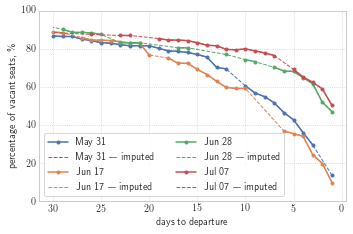

In [10]:
idx = [34, 50, 61, 68]

plt.figure(figsize=(5.5, 3.5))

for i, j in enumerate(idx):
    ts = data_.iloc[j] * 100
    ts_imp = pd.Series(impute_average(ts.values, lim=(0, 100)), index=ts.index)
    
    color = f'C{i}'
    date = data_.index[j].strftime('%b %d')
    
    ts.plot(c=color, marker='.', label=f'{date}')
    ts_imp.plot(c=color, ls='dashed', lw=1, label=f'{date} — imputed')
    
plt.legend(ncol=2, frameon=True)
plt.ylim(0, 100)

plt.gca().invert_xaxis()
plt.xlabel('days to departure')
plt.ylabel('percentage of vacant seats, \\%')

plt.savefig(figures_dir / 'imputation.pdf', transparent=True, bbox_inches='tight')

In [11]:
a = pd.read_csv('../data/model_analysis/principal_components.csv', parse_dates=['date'], index_col=0)
v = pd.read_csv('../data/model_analysis/eigenvectors.csv', index_col=0)
mu = pd.read_csv('../data/model_analysis/means.csv', index_col=0)

v.columns = v.columns.astype(int)
mu.columns = mu.columns.astype(int)

a.columns = a.columns.str.replace('Сидячий', 'Сидячий')
v.index = v.index.str.replace('Сидячий', 'Сидячий')
mu.index = mu.index.str.replace('Сидячий', 'Сидячий')

a.shape, v.shape, mu.shape

((103, 94), (94, 30), (94, 30))

In [12]:
x = np.hstack([v.values, mu.values])

x -= x.mean(axis=0)
x /= x.std(axis=0, ddof=1)

# x = (x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0))

x.shape

(94, 60)

In [13]:
pca = ImputePCA()

pcs = pca.fit_predict(x)

pca.explained_variance_ratio[:10]

array([0.75154283, 0.93560115, 0.97331484, 0.98944478, 0.9951251 ,
       0.99661639, 0.99757525, 0.99814447, 0.99856399, 0.99892106])

In [14]:
pcs = pcs[:, :2]

pcs.shape

(94, 2)

In [15]:
ox = np.linspace(pcs[:, 0].min(), pcs[:, 0].max(), 6)
idx = np.abs(pcs[:, [0]] - ox).argmin(axis=0)
trains = v.index[idx]

trains

Index(['760А-B2', '773А-C2', '705Н-Сидячий', '751А-B2', '776А-B1', '755А-B1'], dtype='object', name='train')

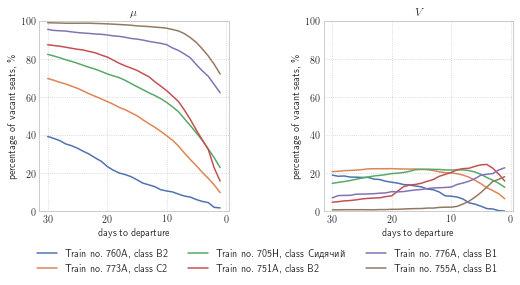

In [16]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(8.5, 3.5)
fig.subplots_adjust(wspace=0.5)
axes = axes.flatten()

for train in trains:
    num, cls = train.split('-')
    label = f'Train no. {num}, class {cls}'
    
    mui = mu.loc[train] * 100
    mui.plot(ax=axes[0], label=label)

    vi = v.loc[train] * 100
    vi.plot(ax=axes[1])
    
axes[0].set_title('$\\mu$')
axes[1].set_title('$V$')

axes[0].legend(loc='upper center', ncol=3, bbox_to_anchor=(1.2, -0.15))
    
for ax in axes:
    ax.invert_xaxis()
    ax.set_xlabel('days to departure')
    ax.set_ylabel('percentage of vacant seats, \\%')
    ax.set_ylim(0, 100)
    
plt.savefig(figures_dir / 'mu_v_examples.pdf', transparent=True, bbox_inches='tight')

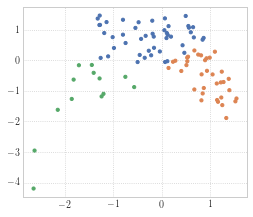

In [17]:
k = 3

kmeans = KMeans(n_clusters=k, random_state=0).fit(pcs)
clusters = kmeans.predict(pcs)

plt.figure(figsize=(4, 3.5))

colors = [f'C{i}' for i in clusters]
plt.scatter(*pcs.T, color=colors, s=10)

plt.savefig(figures_dir / 'mu_v_projections.pdf', transparent=True, bbox_inches='tight')

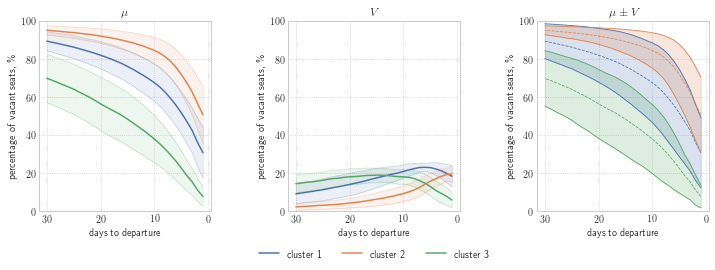

In [18]:
fig, axes = plt.subplots(ncols=3)
fig.set_size_inches(12, 3.5)
fig.subplots_adjust(wspace=0.45)

for i in np.unique(clusters):
    mask = clusters == i
    color = f'C{i}'

    ax = axes[0]
    
    mui = mu.iloc[mask] * 100
    mui_mean = mui.mean(axis=0)
    mui_std = mui.std(axis=0)
    
    ax.plot(mui_mean, c=color)
    
    lower = mui_mean - mui_std
    upper = mui_mean + mui_std
    ax.plot(lower, lw=0.5, alpha=0.3, c=color)
    ax.plot(upper, lw=0.5, alpha=0.3, c=color)
    ax.fill_between(mui_mean.index, lower, upper, alpha=0.1, color=color)
    
    ax = axes[1]
    
    vi = v.iloc[mask] * 100
    vi_mean = vi.mean(axis=0)
    vi_std = vi.std(axis=0)
    
    ax.plot(vi_mean, c=color, label=f'cluster {i + 1}')
    
    lower = vi_mean - vi_std
    upper = vi_mean + vi_std
    ax.plot(lower, lw=0.5, alpha=0.3, c=color)
    ax.plot(upper, lw=0.5, alpha=0.3, c=color)
    ax.fill_between(vi_mean.index, lower, upper, alpha=0.1, color=color)
    
    ax = axes[2]
    
    ax.plot(mui_mean, c=color, ls='dashed', lw=0.8)
    
    lower = mui_mean - vi_mean
    upper = mui_mean + vi_mean
    ax.plot(lower, lw=0.8, c=color)
    ax.plot(upper, lw=0.8, c=color)
    ax.fill_between(vi_mean.index, lower, upper, alpha=0.2, color=color)
    

axes[0].set_title('$\\mu$')
axes[1].set_title('$V$')
axes[2].set_title('$\\mu \\pm V$')
    
for ax in axes:
    ax.invert_xaxis()
    ax.set_xlabel('days to departure')
    ax.set_ylabel('percentage of vacant seats, \\%')
    ax.set_ylim(0, 100)
    

axes[1].legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.15))

plt.savefig(figures_dir / 'mu_v_clusters.pdf', transparent=True, bbox_inches='tight')

In [19]:
df = a.copy()
df['weekday'] = df.index.weekday

df = df.groupby('weekday').mean().T.rename(columns=weekdays)

df.head(2)

weekday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
001А-Купе,0.413662,0.676598,0.416420,0.542463,-0.672912,-0.285485,-1.180378
002А-Купе,0.780929,0.440503,0.551972,-0.670010,-0.673684,0.049775,-0.438934


In [20]:
x = df.values.copy()

x -= x.mean(axis=0)
x /= x.std(axis=0, ddof=1)

x.shape

(94, 7)

In [21]:
pca = ImputePCA()

pcs = pca.fit_predict(df.values)

pca.explained_variance_ratio[:10]

array([0.56131748, 0.80799016, 0.93760083, 0.97048581, 0.9869517 ,
       0.99723211, 1.        ])

In [22]:
pcs = pcs[:, :2]

pcs.shape

(94, 2)

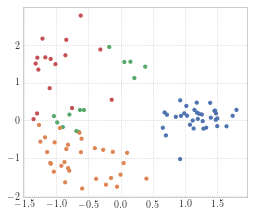

In [23]:
k = 4

kmeans = KMeans(n_clusters=k, n_init=100, random_state=0).fit(df.values)
clusters = kmeans.predict(df.values)

plt.figure(figsize=(4, 3.5))

colors = [f'C{i}' for i in clusters]
plt.scatter(*pcs.T, color=colors, s=10)

plt.savefig(figures_dir / 'a_projections.pdf', transparent=True, bbox_inches='tight')

In [24]:
df_clusters = df.copy()
df_clusters.columns = df_clusters.columns.str.slice(0, 3)
df_clusters['cluster'] = clusters

df_clusters = df_clusters.groupby('cluster').mean()

df_clusters

weekday,Mon,Tue,Wed,Thu,Fri,Sat,Sun
cluster,,,,,,,
0,0.227449,0.516999,0.489430,0.346202,-0.236526,0.198458,-2.015370
1,0.410879,0.362978,0.111828,-0.461294,-1.168000,0.574578,0.074385
2,-0.332961,0.569607,0.582920,0.120966,-0.509698,-0.715338,0.178491
3,-0.796719,-0.350707,-0.027210,-0.054068,0.252605,0.409210,0.523062


In [25]:
cluster_weekends = df_clusters.columns[np.argmin(df_clusters.values, axis=1)]

cluster_weekends

Index(['Sun', 'Fri', 'Sat', 'Mon'], dtype='object', name='weekday')

In [26]:
cluster_names = {
    'Mon': 'to Moscow, before 11am',
    'Sun': 'to Moscow, after 11am',
    'Fri': 'from Moscow, after 11am',
    'Sat': 'from Moscow, before 11am',
}

cluster_names = {i: f'{i + 1} ({cluster_names[weekend]})' for i, weekend in enumerate(cluster_weekends)}

cluster_names

{0: '1 (to Moscow, after 11am)',
 1: '2 (from Moscow, after 11am)',
 2: '3 (from Moscow, before 11am)',
 3: '4 (to Moscow, before 11am)'}

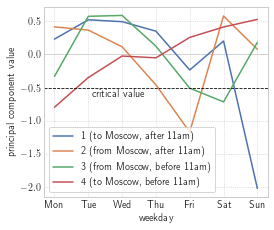

In [27]:
plt.figure(figsize=(4, 3.5))

for i, row in df_clusters.iterrows():
    row.plot(label=cluster_names[i])

cv = -1.96 / np.sqrt(15)
plt.axhline(cv, c='k', lw=0.8, ls='dashed')
plt.text(1.9, cv - 0.02, 'critical value', va='top', ha='center')

plt.axhline(0, c='.8', lw=0.8).set_zorder(1)
plt.ylabel('principal component value')
plt.legend(frameon=True)

plt.savefig(figures_dir / 'a_clusters.pdf', transparent=True, bbox_inches='tight')

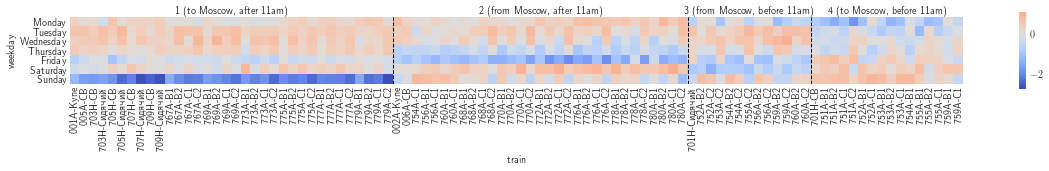

In [28]:
df_ = df.copy()
df_['cluster'] = clusters
df_['train'] = df_.index

df_ = df_.sort_values(by=['cluster', 'train'])

df_ = df_.drop(columns=['cluster', 'train'])

plt.figure(figsize=(20, 1.4))

sns.heatmap(df_.T, square=True, center=0, cmap='coolwarm', xticklabels=True, yticklabels=True, cbar_kws={'aspect': 10})

n = 0

for i, j in pd.Series(clusters).value_counts().sort_index().iteritems():
    plt.text(n + j / 2, -0.1, cluster_names[i], ha='center', va='bottom')
    
    n += j
    
    if i < k - 1:
        plt.axvline(n, c='k', lw=1, ls='dashed')

plt.xlabel('train')

plt.savefig(figures_dir / 'a_heatmap.pdf', transparent=True, bbox_inches='tight')

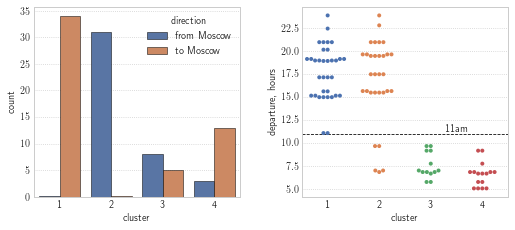

In [29]:
direction = (df.index.str.slice(0, 3).astype(int) % 2).map({0: 'from Moscow', 1: 'to Moscow'})

ctable = pd.crosstab(clusters, direction)

ctable.index.name = 'cluster'
ctable.index += 1
ctable.columns.name = 'direction'

ctable = ctable.reset_index().melt(id_vars='cluster', var_name='direction', value_name='count')
ctable.loc[ctable['count'] == 0, 'count'] += 0.125

departure = data.drop_duplicates('train').set_index('train').reindex(df.index)[['departure_hour']]\
    .rename(columns={'departure_hour': 'departure, hours'})
departure['cluster'] = clusters + 1

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(8.5, 3.5)
fig.subplots_adjust(wspace=0.3)
axes = axes.flatten()

sns.barplot(data=ctable, x='cluster', y='count', hue='direction', ax=axes[0], edgecolor='k', linewidth=0.5)
sns.swarmplot(ax=axes[1], data=departure, x='cluster', y='departure, hours', size=4)

axes[1].axhline(11, ls='dashed', lw=0.8, c='k')
axes[1].text(2.5, 11, '11am', va='bottom', ha='center')

plt.savefig(figures_dir / 'a_clusters_interp.pdf', transparent=True, bbox_inches='tight')

In [34]:
cluster_weekend_ids = np.argmin(df_clusters.values, axis=1)

cluster_weekend_ids

array([6, 4, 5, 0])

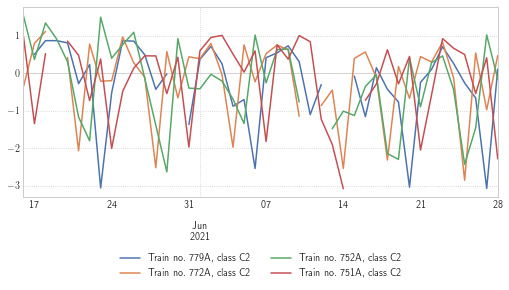

In [69]:
plt.figure(figsize=(8.5, 3.5))

for j in cluster_weekend_ids:
    day_values = df.iloc[:, j]
    train = day_values.index[day_values.argmin()]
    
    ts = a[train].reindex(all_dates)
    
    num, cls = train.split('-')
    label = f'Train no. {num}, class {cls}'
    
    ts.plot(label=label)
    
plt.xlabel(None)
plt.axhline(0, c='.8', lw=0.8).set_zorder(1)
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=2)

plt.savefig(figures_dir / 'a_examples.pdf', transparent=True, bbox_inches='tight')